In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
# import torchvision.transforms as transforms

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

In [97]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

device

device(type='cpu')

In [98]:
import os
if not os.path.exists('data/fmnist'):
    os.makedirs('data/fmnist')

In [99]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = [0.5], std = [0.5])])

In [100]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [101]:
fmnist_ds = torchvision.datasets.FashionMNIST(root='data/fminst', train=True, transform = transform, download=True)

In [102]:
batch_size = 16

fmnist_dl = torch.utils.data.DataLoader(dataset=fmnist_ds, batch_size=batch_size, shuffle=True, drop_last=True)

fmnist_dl

len(fmnist_dl)

3750

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


torch.Size([16, 1, 28, 28])


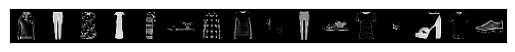

In [103]:
from torchvision.utils import make_grid, save_image
from matplotlib import pyplot as plt

def show_images(img):
    img = img.permute(1, 2, 0)
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.xticks([])
    plt.yticks([])
    plt.show()


for batch_idx, (images,labels) in enumerate(fmnist_dl, 0):
    print(images.shape)
    show_images(make_grid(images, fmnist_dl.batch_size))
    break
    # print(images.shape)
    # for img_idx in range(images.shape[0]):
    #     save_image(images[img_idx], f'{batch_idx}_{img_idx}.jpg')

In [104]:
import os
# Root directory for dataset
# dataroot = f"{os.getcwd()}/data/qmnist"

# Number of workers for dataloader
# workers = 2

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 56

# Size of feature maps in generator
ngf = 28

# Size of feature maps in discriminator
ndf = 28

# Number of training epochs
num_epochs = 2

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])


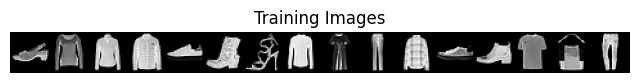

In [105]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(fmnist_dl))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
print(real_batch[0].to(device).shape)
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:batch_size], nrow=16, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [106]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    print(nn.init.normal_)

In [107]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( in_channels=nz, out_channels=ngf * 2, kernel_size= 7, stride = 7, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 7 x 7``
            nn.ConvTranspose2d( ngf * 2, ngf, 6, 2, 0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 14 x 14``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 28 x 28`
        )

    def forward(self, input):
        return self.main(input)
    

In [108]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

noise = torch.randn(batch_size, 56, 1, 1)

G_out = netG(noise)
print(G_out.shape)



<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(56, 56, kernel_size=(7, 7), stride=(7, 7), padding=(1, 1), bias=False)
    (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(56, 28, kernel_size=(6, 6), stride=(2, 2), bias=False)
    (4): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(28, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)
torch.Size([16, 1, 28, 28])


In [109]:
def display_image_grid(images: torch.Tensor, nrow: int):
    image_grid = make_grid(images, nrow)
    print(image_grid.shape)
    image_grid = image_grid.permute(1,2,0)
    image_grid = image_grid.cpu().numpy()
    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5911796..0.63171345].


torch.Size([3, 32, 482])


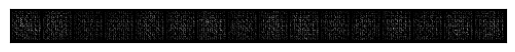

In [110]:
z = torch.randn(batch_size, nz, 1, 1, device=device)

sample_gen_output = netG(z)

img = sample_gen_output.permute(0, 2, 3, 1)
display_image_grid(sample_gen_output, nrow=16)

In [1]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

NameError: name 'nn' is not defined

In [112]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
<function normal_ at 0x109b249a0>
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(28, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(56, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fals

In [113]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [7]:
# Training Descriminator + Generator together

# Lists to keep track of progress
img_list = []
D_losses = []
G_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, real_images in enumerate(fmnist_dl, 0):
        netD.zero_grad()

        # print("Training Discriminator with Real Images..")

        # get output of discriminator by passing real_images through it
        real_img_device = real_images[0].to(device)
        batch_size = real_img_device.size(0)
        D_out_real = netD(real_img_device).view(-1)

        # calculate descriminator loss
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        D_loss_real = criterion(D_out_real, real_labels)

        # compute gradients in backward pass
        D_loss_real.backward()

        # calculate mean of Descriminator output for real images
        D_x= D_out_real.mean().item()

        # print("Training Discriminator with Fake Images..")

        # generate a batch of latent vectors of size nz
        latent_vectors = torch.randn(batch_size, nz, 1, 1, device=device)
        # pass the latent noise through Generator to generate fake images
        fake_images = netG(latent_vectors)
        # print(f'fake_images shape: {fake_images.shape} ')

        # pass the generated fake images through discriminator and get the output
        D_out_fake = netD(fake_images.detach()).view(-1)
        # print(f'D_out_fake shape: {D_out_fake.shape} ')

        # calculate mean of Descriminator output for fake images
        D_G_z1 = D_out_fake.mean().item()

        # calculate descriminator loss
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        D_loss_fake = criterion(D_out_fake, fake_labels)

        # compute gradients in backward pass
        D_loss_fake.backward()

        # compute total discriminator loss and add it to D_losses list
        D_loss = D_loss_real + D_loss_fake
        D_losses.append(D_loss.item())

        # update the gradients
        optimizerD.step()

        
        # print("Training Generator....")
        netG.zero_grad()
        out = netD(fake_images).view(-1)
        G_loss = criterion(out, real_labels)
        G_loss.backward()
        G_losses.append(G_loss)
        D_G_z2 = out.mean().item()
        optimizerG.step()


        if i % 400 == 0:
            print(' Epoch:%d  Batch:%d  D_loss: %.4f G_loss: %.4f D_x: %.4f D_G_z1: %.4f D_G_z2: %.4f'
                  % (epoch, i, D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(fmnist_dl)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))
        iters += 1

Starting Training Loop...


NameError: name 'num_epochs' is not defined

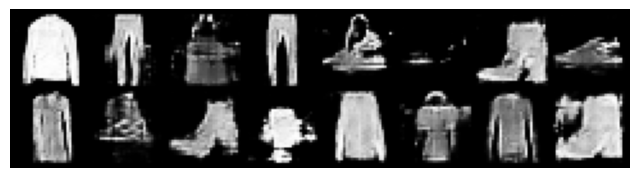

In [116]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

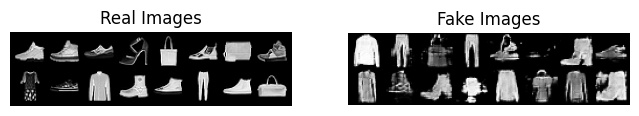

In [117]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(fmnist_dl))

# Plot the real images
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:batch_size], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()